### Regressão logística

Problema de classificar um conjunto de pessoas em adolescente ou adulto dependendo da altura

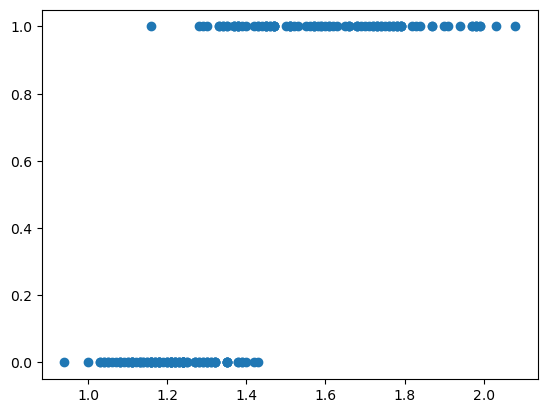

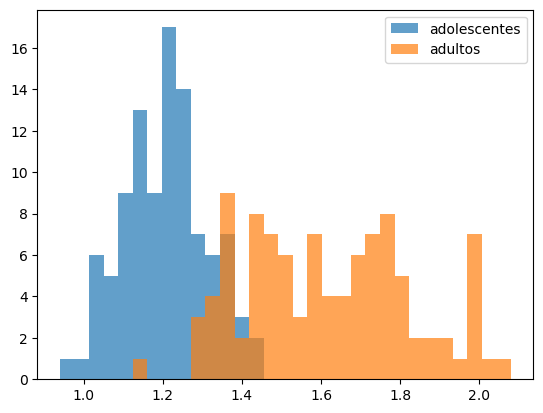

In [89]:
import torch
import matplotlib.pyplot as plt
import numpy as np

data = torch.from_numpy(np.loadtxt('../data/age_data_3.txt'))
x, targets = data.T

plt.scatter(x, targets)
plt.figure()
bins = np.linspace(x.min(), x.max(), 32)
plt.hist(x[targets==0], bins, alpha=0.7)
_ = plt.hist(x[targets==1], bins=bins, alpha=0.7)
plt.legend(('adolescentes', 'adultos'))

In [20]:
# para explicar o que esta acontecendo no plt.hist acima
print(targets==0)
print(x)
print(bins)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

Text(0, 0.5, 'P[Adulto | Altura]')

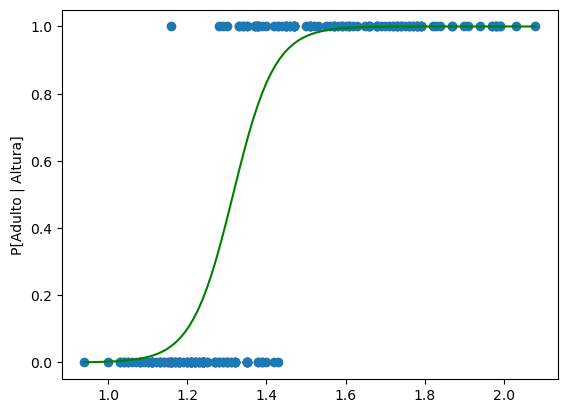

In [70]:
# aplicando modelo linear do jeito que ele eh implementado pelo pytorch

class Model:

    def __init__(self, a, b, requires_grad):
        self.a = torch.tensor(a, requires_grad=requires_grad)
        self.b = torch.tensor(b, requires_grad=requires_grad)

    def __call__(self,x):
        return self.a * x + self.b

    def parameters(self):
        return self.a, self.b
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

# serve para mapear valores para intervalo [0, 1] a depender do tamanho do valor
def sigmoid(x):
    
    return (1/(1+torch.exp(-x)))


model = Model(19., -25., True)
probs = sigmoid(model(x))

xm = torch.linspace(x.min(), x.max(), 100)
scoresm = model(xm)
# valores de y convertidos para probabilidades, valores de 0 a 1
probsm = (sigmoid(scoresm)).detach().numpy() # detach tira do ramo de computaco e numpy converte tensor para numpy 
plt.scatter(x, targets)
plt.plot(xm, probsm, c='g')
plt.ylabel('P[Adulto | Altura]')

In [53]:
# como medir a eficiencia, os acertos do modelo? acuracia eh uma medida
# calcula qtd_acertos / n
def acc(preds, targets):
    return torch.sum(preds==targets)/len(targets)

a = torch.tensor([1, 1, 0])
b = torch.tensor([1, 0, 0])
# ao aplicar sum, True = 1 e False = 0; maneira de contabilizar numero de acertos
print(a == b)

print(acc(probs > 0.5, targets))

# sempre que se aplica operacao booleana que envolva um vetor numpy ou tensor ele aplica pra todos elementos e 
# retorna um array [False, True, True, ...] por exemplo

tensor([ True, False,  True])
tensor(0.9000)


verossimilhança: maneira de medir aderencia de um modelo ao modelo ideal

no modelo ideal, se todas instancias da classe x forem corretamente avaliadas, entao P[classex | altura] = 1; Logo, ao multiplicar todas probabilidades de todas instancias, obteria-se produto(Probs) = 1

para testar modelo real, multiplica-se probabilidades das instâncias 

In [72]:
def probs_correct(probs, targets):
    probs_correct = torch.zeros(len(targets))
    for i, target in enumerate(targets):
        if (target == 1):
            probs_correct[i] = probs[i]
        else:
            probs_correct[i] = 1 - probs[i]

    return probs_correct    

    # outra opcao
    # return targets*probs + (1-probs)*(1-targets)

def likehood(probs, targets):

    return torch.prod(probs_correct(probs, targets))

likehood(probs, targets)

tensor(2.2591e-20, grad_fn=<ProdBackward0>)

In [74]:
# para evitar valores muito baixos, pode-se usar not-likehood que eh o negativo do log da funcao de verossimilhanca
# evitar numeros muito pequenos esta relacionado a estabilidade numerica
def nll(probs, targets):
    probs_correct_ = probs_correct(probs, targets)
    probs_log = torch.log(probs_correct_)
    return -torch.sum(probs_log) # log de produtorio vira somatorio

nll(probs, targets)

# nesse caso nll retornaria 0 para o modelo perfeito

tensor(45.2367, grad_fn=<NegBackward0>)

In [87]:
# entropia cruzada, eh funcao equivalente a nll no problema considerado; recebe scores e nao prob
# media eh retornada para que valores sejam mais estaveis numericamente, mas na funcao do pytorch pode ser retornada soma
# retorna valor negativo pois log gera valores negativos para valores decimais 
# valor negativo gera valor positivo que deve ser minimizado
def cross_entropy(scores, targets):

    probs = sigmoid(scores)
    probs_correct_ = probs_correct(probs, targets)
    probs_log = torch.log(probs_correct_)
    return -torch.mean(probs_log)

scores = model(x)
cross_entropy(scores, targets)

tensor(0.2262, grad_fn=<NegBackward0>)

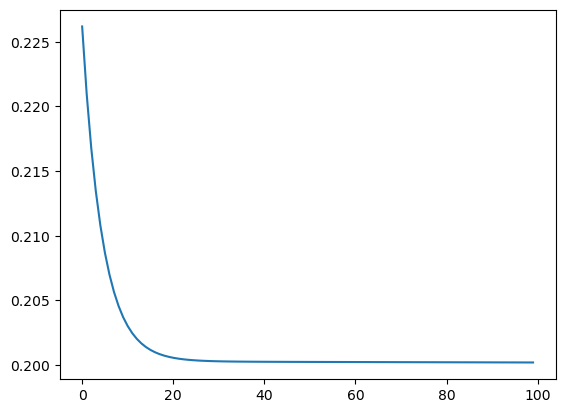

In [91]:
# otimizacao do modelo
def step(model, x, targets, lr=0.5):

    model.zero_grad()
    scores = model(x)
    loss = cross_entropy(scores, targets)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p -= p.grad*lr

    return loss.item()

model = Model(19., -25., requires_grad=True)
num_epochs = 100
lr = 0.5
losses = []
for _ in range(0, num_epochs):
    loss = step(model, x, targets, lr)
    losses.append(loss)

plt.plot(losses)
